In [1]:
import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='svg'

In [2]:
# Create a SuperpoweredDecoder and open an audio file
import superpowered
from superpowered.decoder import Decoder
decoder = Decoder()
decoder.open('./spotify-track-1Ew3CCat8okts5yG4I5LpA.mp3')

In [3]:
# Read all samples (as single precision float)
samples = decoder.read()

# Interleaved stereo audio is represented by an ndarray of shape (numSamples, numChannels)
samples.shape, samples.dtype

((1325952, 2), dtype('float32'))

In [4]:
# Apply a lowpass filter to audio
from superpowered.filter import Filter, FilterType

# Create a SuperpoweredFilter of type Resonant_Lowpass
f = Filter(FilterType.Resonant_Lowpass, decoder.samplerate)
f.setResonantParameters(400.0, 0.1)
f.enable(True)

# Process all samples
f.process(samples, samples)  # input and output can be the same

In [7]:
# Alternatively, decode file and process frame by frame
from superpowered.recorder import WAV
from superpowered.simple import short_int_to_float, float_to_short_int

# Create an output WAV file
wav = WAV('output.wav', decoder.samplerate, 2)

# Seek to start of audio file
decoder.getAudioStartSample(decibel=-27)

# Create a buffer to hold samples while we process
# Include scratch space at the end
buffer = np.empty((decoder.samplesPerFrame, 2), dtype=np.float32)

# Returns a DecoderIterator that iterates through frames of
# size `decoder.samplesPerFrame` of interleaved 16-bit samples
for frame in decoder:
    # frame is an ndarray of shape (decoder.samplesPerFrame, numChannels)
    # Convert frame samples to single precision float
    short_int_to_float(frame, buffer)
    
    # Apply filter
    f.process(buffer, buffer)

    float_to_short_int(buffer, frame)
    
    # Do something with the processed samples
    wav.write(frame)

# Close WAV file (file is also closed when wav is garbage collected)
wav.close()

In [8]:
# Analyzer audio
from superpowered.analyzer import OfflineAnalyzer

# Create a SuperpoweredOfflineAnalyzer
analyzer = OfflineAnalyzer(decoder.samplerate, 0, decoder.durationSeconds)

# Process all samples
analyzer.process(samples)

# Get results
info = analyzer.getresults()
info

{'averageDecibel': -12.599625587463379,
 'averageWaveform': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'beatgridStartMs': 205.86553955078125,
 'bpm': 101.05999755859375,
 'highWaveform': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'keyIndex': 0,
 'loudpartsAverageDecibel': -12.079463958740234,
 'lowWaveform': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'midWaveform': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'notes': array([204, 204, 204, ...,  27,  25,  25], dtype=uint8),
 'overviewSize': 31,
 'overviewWaveform': array([  -3,   -2,   -3,   -2,   -2,   -4,   -4,   -3,   -3,   -4,   -3,
          -5,   -1,    0,   -1,    0,    0,   -1,   -1,    0,    0,   -1,
           0,   -1,   -1,    0,    0,   -1,   -3,   -3, -128], dtype=int8),
 'peakDecibel': -0.38412603735923767,
 'peakWaveform': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'waveformSize': 4510}

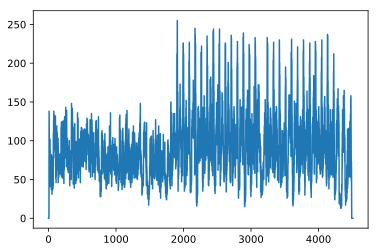

In [9]:
plt.plot(info['averageWaveform'])

In [10]:
# Adjust tempo and pitch
from superpowered.timestretching import stretch

# Choose rate & pitch shift
rateShift = 1.04
pitchShift = 2

# Process samples
stretch(samples, decoder.samplerate, rateShift, pitchShift)

array([[  0.00000000e+00,   0.00000000e+00],
       [ -3.92740582e-14,   3.06060759e-13],
       [ -3.17389832e-13,   2.40748415e-12],
       ..., 
       [  0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00]], dtype=float32)

In [11]:
# Adjust tempo and pitch using SuperpoweredTimeStretching
from superpowered.audiobuffers import AudiopointerList, AudiobufferlistElement
from superpowered.timestretching import TimeStretching

outputBuffers = AudiopointerList(8, 16)
timeStretch = TimeStretching(decoder.samplerate)
timeStretch.setRateAndPitchShift(1.04, 1)

# ...

In [12]:
# Apply bandpass filterbank to create spectrogram
from vinyl.filterbank import BandpassFilterbank

# Choose band frequencies and widths
frequencies = np.logspace(2, 3, 64, dtype=np.float32)
widths = 1 / frequencies

# Create a SuperpoweredBandpassFilterbank
fb = BandpassFilterbank(frequencies, widths, decoder.samplerate)

# Process samples
bands = fb.process(samples, chunks=512)
# bands = fb.process(samples, chunksize=1024)  # Alternatively, specify chunk size

bands.shape

(512, 64)

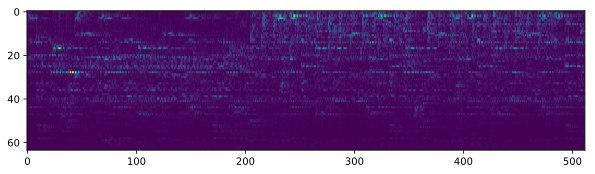

In [13]:
# Visualize spectrogram
plt.figure(figsize=(10,6))
plt.imshow(bands.T, aspect=2)